[Reference](https://towardsdatascience.com/clothes-reviews-analysis-with-nlp-part-1-bfb8a3a2c4bd)

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
!pwd
os.chdir('gdrive/My Drive/Colab Notebooks')
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks


In [2]:
import pandas as pd
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [3]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
df.shape

(23486, 11)

In [5]:
#data cleaning

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df.shape

(19662, 11)

In [7]:
import re
for i in range(len(df)):
    #print(i)
    df['Review Text'][i] = df['Review Text'][i].replace("'s", " is").replace("'ll", " will").replace("'ve", " have").replace("'m", " am").replace("\'", "'")
    
df['Review Text'][1]
df = df.drop('Unnamed: 0', 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
#data preprocessingimport nltk
import en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.corpus import stopwords

def lemmatization(df):
    df["Lemmas"] = [" ".join([token.lemma_ if token.lemma_ != "-PRON-" else token.text.lower() 
    for sentence in nlp(speech).sents for token in sentence if 
    token.pos_ in {"NOUN", "VERB", "ADJ", "ADV", "X"} and  
    token.is_stop == False]) for speech in df.text]
    
df["Lemmas"] = [" ".join([token.lemma_ if token.lemma_ != "-PRON-" 
                else token.text.lower() for sentence in 
                nlp(speech).sents for token in sentence if 
                token.pos_ in {"NOUN", "VERB", "ADJ", "ADV", "X"} 
                and token.is_stop == False]) for speech in 
                df['Review Text']]
                
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Lemmas
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hope dress want work initially order peti...
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it is fun, f...",5,1,0,General Petite,Bottoms,Pants,love love love jumpsuit fun flirty fabulous ti...
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,shirt flattering adjustable tie perfect length...
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,love tracy reese dress foot tall usually wear ...
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,ade basket mintue look person store pick go da...


In [35]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

In [36]:
df['Rating'].value_counts()

5    10858
4     4289
3     2464
2     1360
1      691
Name: Rating, dtype: int64

In [40]:
df_factor = df.join(pd.DataFrame(mlb.fit_transform(df['Rating'].astype(str)),columns=mlb.classes_,index=df.index))
df_factor.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Lemmas,1,2,3,4,5
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hope dress want work initially order peti...,0,0,1,0,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it is fun, f...",5,1,0,General Petite,Bottoms,Pants,love love love jumpsuit fun flirty fabulous ti...,0,0,0,0,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,shirt flattering adjustable tie perfect length...,0,0,0,0,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,love tracy reese dress foot tall usually wear ...,0,1,0,0,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,ade basket mintue look person store pick go da...,0,0,0,0,1


In [41]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Activation, Dropout
from tensorflow.python.keras.optimizers import SGD

#diseabling eager execution
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

import pandas as pd
from sklearn.model_selection import train_test_split

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [45]:
train, test = train_test_split(df_factor, test_size=0.2)

vectorizer_nn = TfidfVectorizer(ngram_range = (1, 2), min_df = 0.001, max_df = 0.25, stop_words = 'english')

X_train_nn = vectorizer_nn.fit_transform(train.Lemmas)
X_test_nn = vectorizer_nn.transform(test.Lemmas)

y_train = train.drop(["Clothing ID", "Age", "Title", "Review Text", "Rating", "Recommended IND", "Lemmas", "Positive Feedback Count", "Division Name", "Department Name", "Class Name"], axis = 1)
y_test = test.drop(["Clothing ID", "Age", "Title", "Review Text", "Rating", "Recommended IND", "Lemmas", "Positive Feedback Count", "Division Name", "Department Name", "Class Name"], axis = 1)

In [46]:
model = Sequential()
model.add(Dense(5000, activation='relu', input_dim = X_train_nn.shape[1]))
model.add(Dropout(0.1))
model.add(Dense(600, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1], activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy',])
score = model.evaluate(X_test_nn, y_test, batch_size = 7000)
score

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


[1.606174349784851, 0.36562422]

Train on 11796 samples, validate on 3933 samples
Epoch 1/10
11796/11796 [==============================] - 11s 931us/sample - loss: 1.6029 - accuracy: 0.4277 - val_loss: 1.5898 - val_accuracy: 0.5510
Epoch 2/10
11796/11796 [==============================] - 11s 967us/sample - loss: 1.5846 - accuracy: 0.5574 - val_loss: 1.5643 - val_accuracy: 0.5510
Epoch 3/10
11796/11796 [==============================] - 11s 952us/sample - loss: 1.5573 - accuracy: 0.5574 - val_loss: 1.5323 - val_accuracy: 0.5510
Epoch 4/10
11796/11796 [==============================] - 11s 942us/sample - loss: 1.5240 - accuracy: 0.5574 - val_loss: 1.4953 - val_accuracy: 0.5510
Epoch 5/10
11796/11796 [==============================] - 11s 938us/sample - loss: 1.4856 - accuracy: 0.5574 - val_loss: 1.4554 - val_accuracy: 0.5510
Epoch 6/10
11796/11796 [==============================] - 11s 932us/sample - loss: 1.4448 - accuracy: 0.5574 - val_loss: 1.4152 - val_accuracy: 0.5510
Epoch 7/10
11796/11796 [=====================

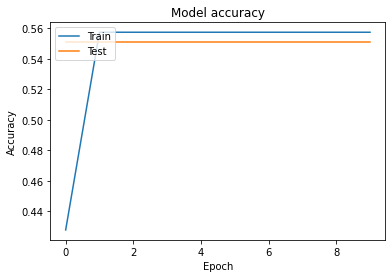

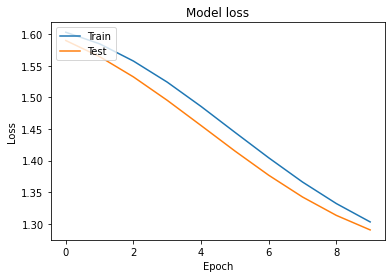

In [47]:
import matplotlib.pyplot as plt

history = model.fit(X_train_nn, y_train, validation_split=0.25, epochs = 10, batch_size = 7000, verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()